# 오토 인코더
Francois Chollet가 작성한 [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)에서 가져온 코드 예제를 약간 수정했습니다. 해당 내용 중 전통적 오토 인코더에 해당하는 부분만 다뤘습니다. 위 링크에 코드와 오토 인코더에 대한 자세한 영문 설명이 있습니다.

![alt text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

오토 인코더: 원본 이미지를 압축한 뒤 원래 이미지로 복원되도록 학습시킵니다. 그러면 이미지를 압축시킬 때, 원본 이미지에서 가장 중요한 표현들만 남도록 학습하게 됩니다.



## 가장 간단한 오토 인코더

In [1]:
from keras.datasets import mnist
import numpy as np

# mnist 데이터 사용. 레이블은 사용하지 않는다.
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))
print(x_train.shape)
print(x_test.shape)

Using TensorFlow backend.


(60000, 784)
(10000, 784)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Validation loss 0.0979155163526535


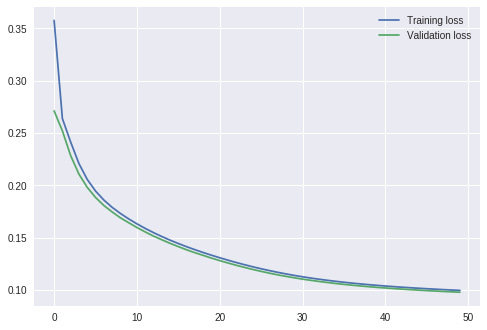

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 36   # 압축 이미지의 크기 설정.

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# 원본 이미지를 압축-복원하는 모델
autoencoder = Model(input_img, decoded)

# 원본 이미지를 압축하는 모델
encoder = Model(input_img, encoded)

# 압축 이미지를 복원하는 모델
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history =autoencoder.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        validation_data=(x_test, x_test),
                        verbose=False) # 학습 진행상황을 보지 않는다.

# 손실값 계산
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Validation loss", val_loss[-1])

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

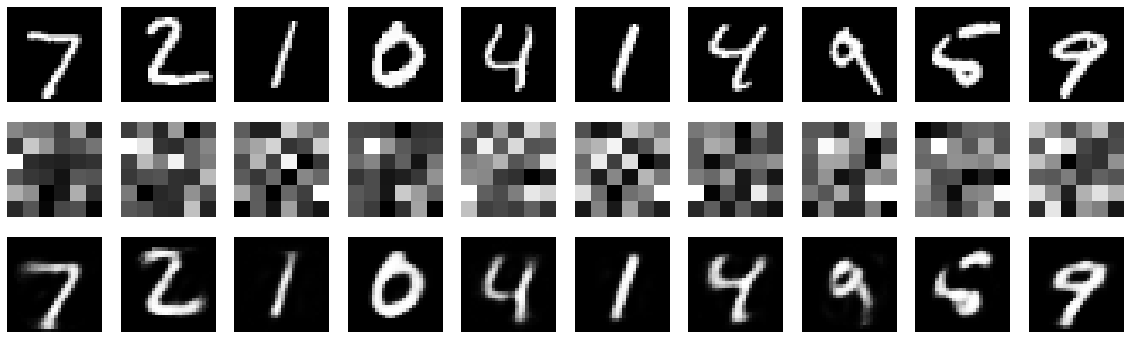

In [3]:
# 이제 압축/복원된 이미지를 그려보자. (테스트 이미지에 대해 그려볼 것)
import matplotlib.pyplot as plt

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(20, 6))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded imgs
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(6, 6))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()  # 이미지가 완전히 복원되지는 않는다.

## 희소하게 인코딩하기
위에서 한 간단한 인코더는 PCA를 근사합니다. 이번에는 인코더에 규제를 추가하여  압축된 표현을 희소하게 만들 것입니다. 인코더에 제약을 가하면 인코더는 입력 이미지를 적은 수의 비트에 압축하고자 노력합니다.

Validation loss 0.12929358705282212


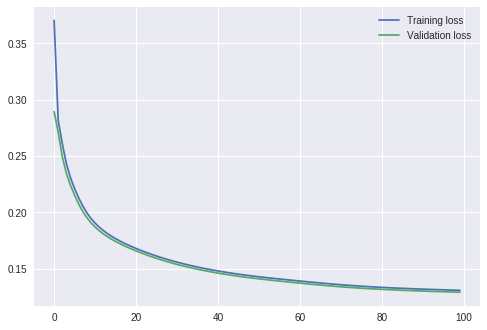

In [4]:
from keras import regularizers

encoding_dim = 36

# 밀집연결 층에 L1 규제를 가한다.
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# 원본 이미지를 압축-복원하는 모델
autoencoder = Model(input_img, decoded)

# 원본 이미지를 압축하는 모델
encoder = Model(input_img, encoded)

# 압축 이미지를 복원하는 모델
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# 규제를 가했으므로, 훈련 횟수를 늘린다.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size=256,
                          validation_data=(x_test, x_test),
                          verbose=False)

# 손실값 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Validation loss", val_loss[-1])

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

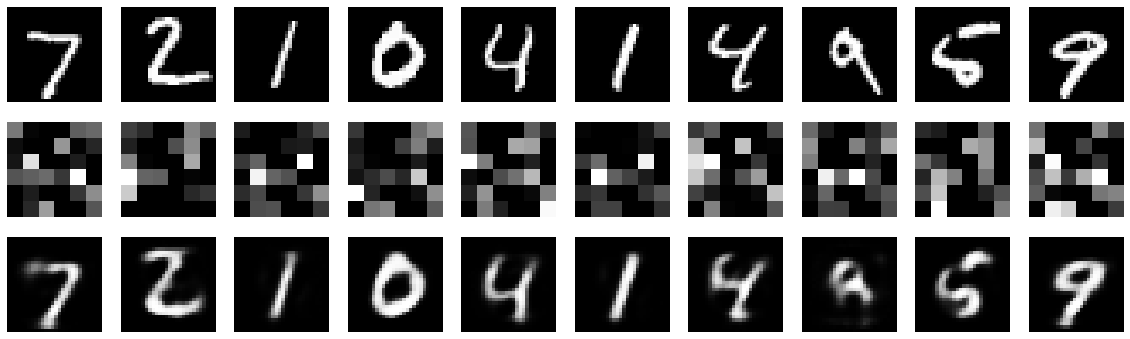

In [5]:
# 이제 압축/복원된 테스트 이미지를 그려보자.
import matplotlib.pyplot as plt

encoded_imgs_sparse = encoder.predict(x_test)
decoded_imgs_sparse = decoder.predict(encoded_imgs_sparse)

n = 10
plt.figure(figsize=(20, 6))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded imgs
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_sparse[i].reshape(6, 6))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs_sparse[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show() # 압축된 표현에 검은 부분이 많아졌음을 볼 수 있다. (픽셀값이 작을수록 검게 보인다)

In [6]:
# 압축된 이미지의 평균값이 낮아졌다.
print(np.mean(encoded_imgs))
print(np.mean(encoded_imgs_sparse))

7.1194034
1.6324219


## 딥 오토 인코더

Validation loss 0.09741324572563172


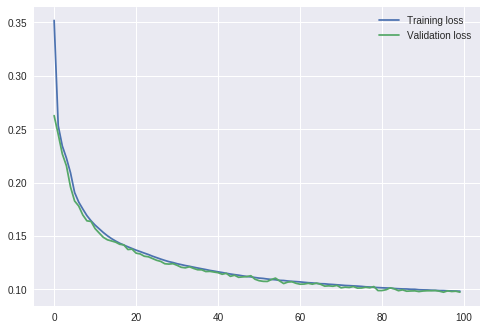

In [7]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(36, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=False)

loss = history.history['loss']
val_loss = history.history['val_loss']
print("Validation loss", val_loss[-1])

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show() # 층을 깊게 하니 손실값이 줄어들었다.

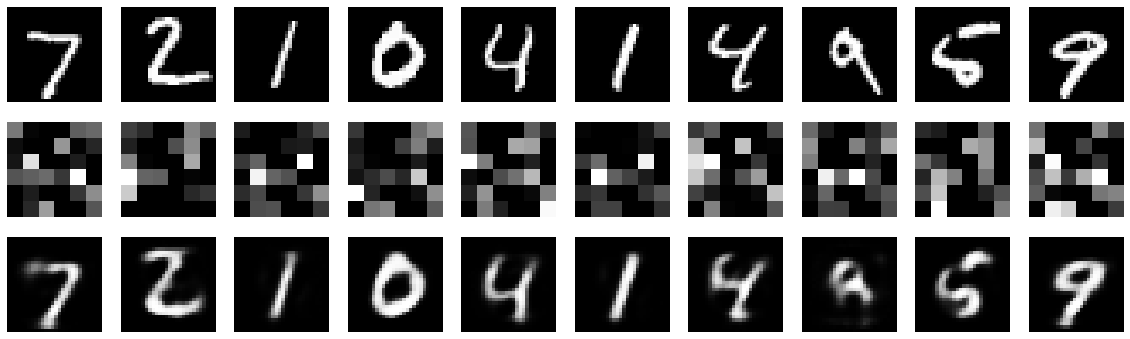

In [8]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(20, 6))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded imgs
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(6, 6))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show() 

## 합성곱 오토 인코더

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 합성곱 층에 넣기 위해 이미지 데이터 크기를 조정해준다.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Validation loss 0.09705395723581314


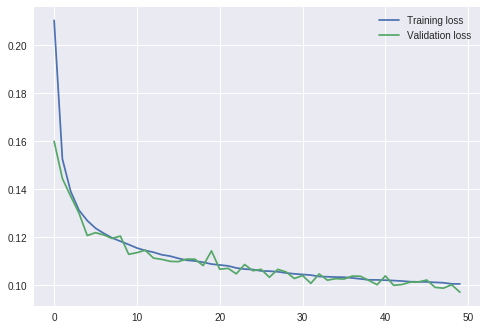

In [10]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 이 시점에서 압축된 표현의 크기는 (4, 4, 8)가 된다.

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)                     # 복원 이미지의 크기를 맞추기 위해 padding을 쓰지 않는다.
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)


autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=False)

loss = history.history['loss']
val_loss = history.history['val_loss']
print("Validation loss", val_loss[-1])

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show() 

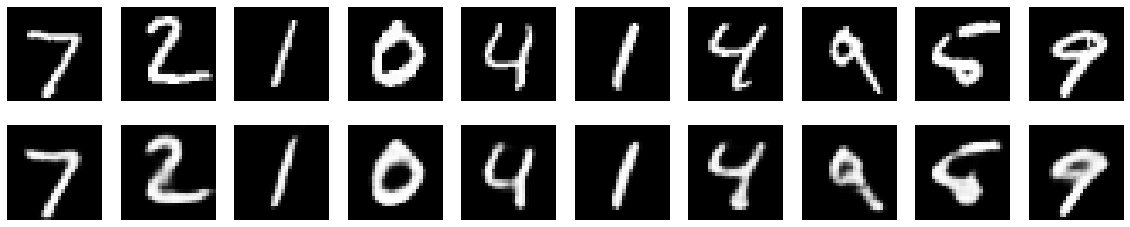

In [11]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 인코딩된 표현 시각화

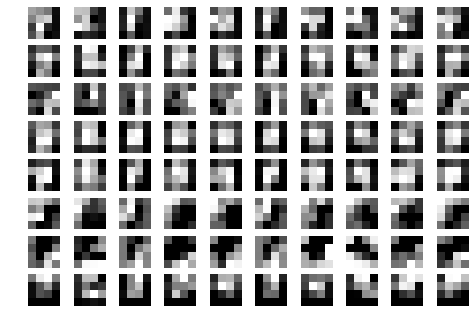

In [12]:
encoded_imgs = encoder.predict(x_test)
plt.gray()
for i in range(10):
    for j in range(8):
      ax = plt.subplot(8, 10, i + j*10 + 1)
      plt.imshow(encoded_imgs[i, :, :, j])
      plt.axis('off') # 필터별 시각화

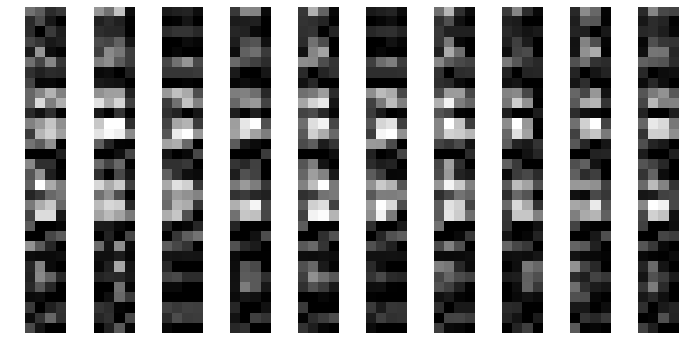

In [13]:
n = 10
plt.figure(figsize=(12, 6))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.axis('off')
plt.show()

## 오토 인코더 응용: 노이즈 없애기

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

# 이미지에 가우시안 노이즈를 추가한다.
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# 픽셀 값을 0~1 사이에서 벗어난 값은 잘라준다.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

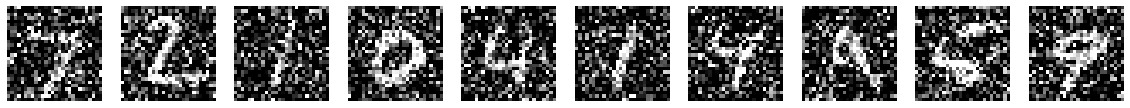

In [15]:
n = 10
plt.figure(figsize=(20, 2))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

성능을 향상시키기 위해, 이전에 사용한 합성곱 층을 약간 변형합니다.

In [0]:
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 이 시점에서 압축된 표현의 크기는 (7, 7, 32)이다. 여기에 중요한 표현만이 압축적으로 남게 된다.

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=128,
                validation_data=(x_test_noisy, x_test),
                verbose=False)

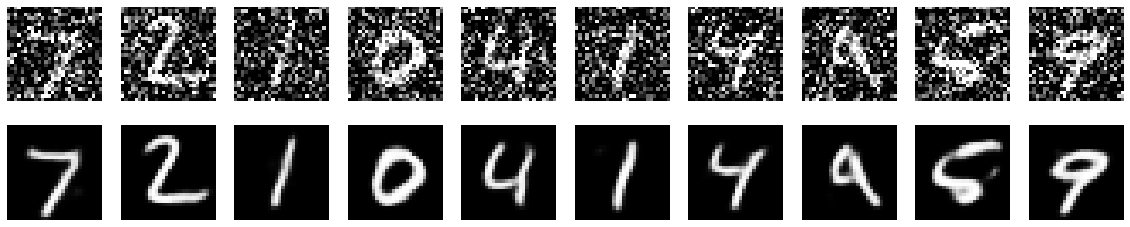

In [17]:
decoded_imgs = autoencoder.predict(x_test_noisy) # 노이즈가 낀 이미지를 받아서 복원된 이미지를 반환하는 모델

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 노이즈가 낀 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 복원된 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

비슷한 방식으로 오디오나 문서에 낀 노이즈를 제거할 수 있습니다. [캐글에 연습할 만한 데이터](https://www.kaggle.com/c/denoising-dirty-documents)가 있습니다.